In [4]:
import numpy as np
import pandas as pd

# Define the path to the validation sample file
# As specified in WORKSPACE_STRUCTURE.md
file_path = '/workspaces/swe-pinn/data/one_building_DEM_zero/validation_sample.npy'

# Define the column names for the DataFrame
columns = ['t', 'x', 'y', 'h', 'u', 'v']

try:
    # Load the .npy file
    # Using mmap_mode='r' is good practice for large files, though not strictly necessary for the smaller sample file
    data = np.load(file_path, mmap_mode='r')

    # Create a pandas DataFrame
    df = pd.DataFrame(data, columns=columns)

    # Display the first few rows of the DataFrame to verify
    print("--- First 5 rows of the DataFrame ---")
    print(df.head())
    print("\\n" + "="*40 + "\\n")

    # Show the statistical description of the DataFrame
    print("--- Statistical Description of the Data ---")
    print(df.describe())

except FileNotFoundError:
    print(f"Error: The file was not found at the specified path: {file_path}")
    print("Please ensure the file exists and the path is correct.")
except Exception as e:
    print(f"An error occurred: {e}")

--- First 5 rows of the DataFrame ---
     t           x          y    h    u    v
0  0.0   62.013233   2.047242  0.0  0.0  0.0
1  1.0  359.142334  36.818726  0.0  0.0  0.0
2  1.0  512.796204  57.452450  0.0  0.0  0.0
3  1.0  550.310913  50.106606  0.0  0.0  0.0
4  1.0  842.784485  34.289436  0.0  0.0  0.0
\n========================================\n
--- Statistical Description of the Data ---
                  t             x             y             h             u  \
count  15000.000000  15000.000000  15000.000000  15000.000000  15000.000000   
mean    1789.775391    600.617188     50.222576      0.120026      0.115151   
std     1035.785889    345.210510     28.827194      0.162146      0.143827   
min        0.000000      0.159233      0.187765      0.000000     -0.049276   
25%      901.000000    301.124512     25.338558      0.000000      0.000000   
50%     1784.000000    596.314941     50.316008      0.000000      0.000000   
75%     2685.000000    902.554169     75.103376   

Successfully loaded real building boundaries from config file.
\nStarting to process the large file: /workspaces/swe-pinn/data/one_building_DEM_zero/validation_tensor.npy
This may take a few minutes...
Successfully opened memory-mapped file with 1,009,619,732 rows.
  Processed 10,000,000 / 1,009,619,732 rows...
  Processed 20,000,000 / 1,009,619,732 rows...
  Processed 30,000,000 / 1,009,619,732 rows...
  Processed 40,000,000 / 1,009,619,732 rows...
  Processed 50,000,000 / 1,009,619,732 rows...
  Processed 60,000,000 / 1,009,619,732 rows...
  Processed 70,000,000 / 1,009,619,732 rows...
  Processed 10,000,000 / 1,009,619,732 rows...
  Processed 20,000,000 / 1,009,619,732 rows...
  Processed 30,000,000 / 1,009,619,732 rows...
  Processed 40,000,000 / 1,009,619,732 rows...
  Processed 50,000,000 / 1,009,619,732 rows...
  Processed 60,000,000 / 1,009,619,732 rows...
  Processed 70,000,000 / 1,009,619,732 rows...
  Processed 80,000,000 / 1,009,619,732 rows...
  Processed 90,000,000 / 1,00

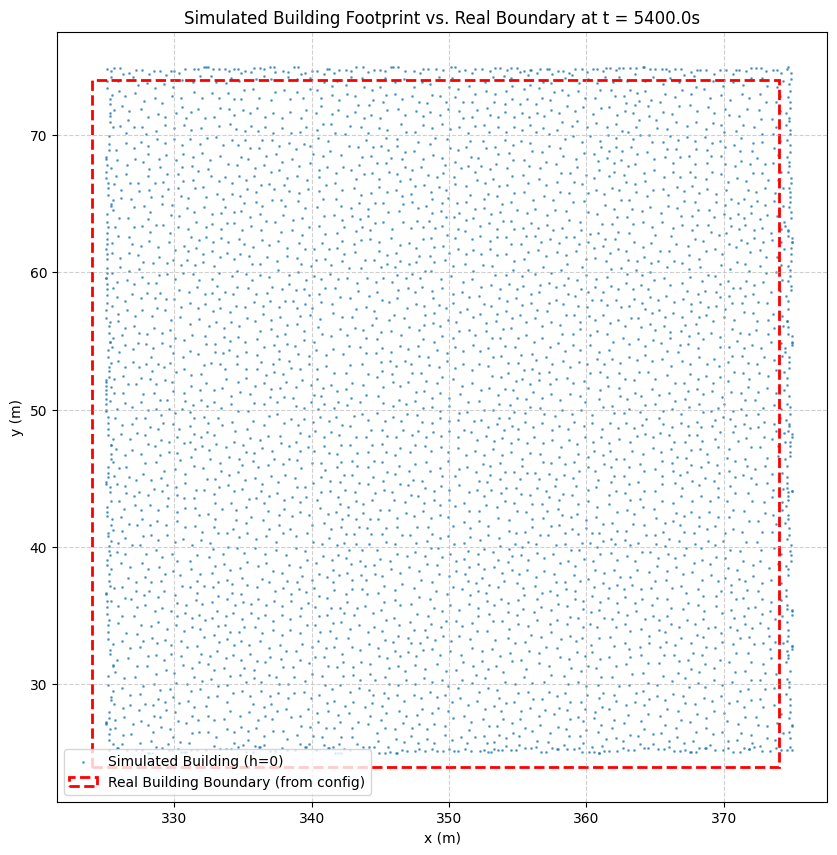

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import yaml
import time

# --- Configuration ---
VALIDATION_FILE_PATH = '/workspaces/swe-pinn/data/one_building_DEM_zero/validation_tensor.npy'
CONFIG_FILE_PATH = '/workspaces/swe-pinn/experiments/one_building_config.yaml'
TARGET_TIME = 5400.0
CHUNK_SIZE = 10_000_000  # Process 10 million rows at a time

# --- 1. Load Real Building Boundaries from YAML Config ---
try:
    with open(CONFIG_FILE_PATH, 'r') as f:
        config = yaml.safe_load(f)
        building_config = config['building']
        x_min = building_config['x_min'] - 1
        x_max = building_config['x_max'] + 1
        y_min = building_config['y_min'] - 1
        y_max = building_config['y_max'] + 1
    print("Successfully loaded real building boundaries from config file.")
except FileNotFoundError:
    print(f"ERROR: Config file not found at {CONFIG_FILE_PATH}")
    # Set to None to prevent plotting errors later
    x_min, x_max, y_min, y_max = None, None, None, None
except Exception as e:
    print(f"An error occurred while reading the config file: {e}")
    x_min, x_max, y_min, y_max = None, None, None, None


# --- 2. Process Large Validation File for Simulated Footprint ---
building_x = []
building_y = []

print(f"\\nStarting to process the large file: {VALIDATION_FILE_PATH}")
print("This may take a few minutes...")

try:
    # Use memory-mapping to handle the large file
    validation_tensor = np.load(VALIDATION_FILE_PATH, mmap_mode='r')
    num_rows = validation_tensor.shape[0]
    print(f"Successfully opened memory-mapped file with {num_rows:,} rows.")

    start_time = time.time()

    # Process in chunks to manage memory efficiently
    for i in range(0, num_rows, CHUNK_SIZE):
        chunk_end = min(i + CHUNK_SIZE, num_rows)
        chunk = validation_tensor[i:chunk_end]

        # Filter for points at the target time with zero water depth
        mask = (chunk[:, 0] == TARGET_TIME) & (chunk[:, 3] == 0)
        building_points = chunk[mask]

        if building_points.shape[0] > 0:
            building_x.extend(building_points[:, 1])  # 'x' coordinates
            building_y.extend(building_points[:, 2])  # 'y' coordinates
        
        print(f"  Processed {chunk_end:,} / {num_rows:,} rows...")

    end_time = time.time()
    print(f"\\nProcessing finished in {end_time - start_time:.2f} seconds.")

    # --- 3. Plotting Both Datasets ---
    if len(building_x) > 0:
        print(f"Found {len(building_x):,} points representing the simulated building.")
        
        fig, ax = plt.subplots(figsize=(12, 10))
        
        # Plot the simulated building points (h=0)
        ax.scatter(building_x, building_y, s=1, alpha=0.6, label='Simulated Building (h=0)')
        
        # Add the real building boundary from the config file if loaded successfully
        if x_min is not None:
            rect = patches.Rectangle(
                (x_min, y_min), (x_max - x_min), (y_max - y_min),
                linewidth=2, edgecolor='r', facecolor='none', linestyle='--',
                label='Real Building Boundary (from config)'
            )
            ax.add_patch(rect)
        
        ax.set_title(f'Simulated Building Footprint vs. Real Boundary at t = {TARGET_TIME}s')
        ax.set_xlabel('x (m)')
        ax.set_ylabel('y (m)')
        ax.grid(True, linestyle='--', alpha=0.6)
        ax.set_aspect('equal', adjustable='box')
        ax.legend()
        plt.show()
        
    else:
        print(f"No data points found for t = {TARGET_TIME}s where h = 0.")

except FileNotFoundError:
    print(f"ERROR: The validation file was not found at {VALIDATION_FILE_PATH}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")